In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xtquant import xtdata
import datetime
import dateutil

#TODO: what if the portfolio inclue equity across the market
market = 'SH'

class Context:
    def __init__(self, market, cash, bkt_start_date, bkt_end_date):
        self.market = market
        self.cash = cash
        self.bkt_start_date = bkt_start_date
        self.bkt_end_date = bkt_end_date
        self.positions = {}
        self.benchmark = None
        self.date_range = xtdata.get_trading_calendar(market, bkt_start_date, bkt_end_date)
        self.bkt_dt = None

context = Context(market, 100000000, '20160101', '20170101')
#print(context.date_range)

class G:
    pass

g = G()

def set_benchmark(code):
    context.benchmark = code

def get_hist_data_by_count(code, count, fields=['open', 'close', 'high', 'low', 'volume', 'preClose']):
    hist_end_date = (dateutil.parser.parse(context.bkt_dt) - datetime.timedelta(days=1)).strftime("%Y%m%d")

    trd_calendar = xtdata.get_trading_calendar(context.market)
    hist_start_date = [dt for dt in trd_calendar if dt <= hist_end_date][-count:][0]

    _period = '1d'
    code = code+"."+context.market
    xtdata.download_history_data(code, _period, hist_start_date, hist_end_date)

    ret = xtdata.get_market_data_ex(field_list=fields,
                                    stock_list=[code],
                                    period=_period,
                                    start_time='',
                                    end_time=hist_end_date,
                                    count=count
            )

    return ret

def get_hist_data_by_daterange(code, hist_start_date, hist_end_date, fields=['open', 'close', 'high', 'low', 'volume', 'preClose']):
    _period = '1d'
    code = code+"."+context.market
    xtdata.download_history_data(code, _period, hist_start_date, hist_end_date)

    ret = xtdata.get_market_data_ex(field_list=fields,
                                    stock_list=[code],
                                    period=_period,
                                    start_time=hist_start_date,
                                    end_time=hist_end_date,
                                    count=-1
            )

    return ret




def get_today_data(code, fields=['open', 'close', 'high', 'low', 'volume', 'preClose']):
    _period = '1d'
    _count = 1
    code = code+"."+context.market
    today = context.bkt_dt
    xtdata.download_history_data(code, _period, today, today)

    try:
        ret = xtdata.get_market_data_ex(field_list=fields,
                stock_list=[code],
                period=_period,
                start_time='',
                end_time=today,
                count=_count
                )[code]
    except KeyError:
        ret = pd.Series()

    return ret

def _order(code, amount):
    today_data = get_today_data(code)
    if len(today_data) == 0:
        print('no trading today')
        return

    price = today_data['open'].values[0]
    if context.cash - amount * price < 0:
        amount = int(context.cash / price)
        print('not enough cash, adjusted to %d' %(amount))

    if amount % 100 != 0:
        #if sold all you have, not need to adjust
        if amount != -context.positions.get(code, 0):
            amount = int(amount / 100) * 100
            print('adjusted to buyable amount %d' % amount)

    # adjust when selling all you have
    if context.positions.get(code, 0) < -amount:
        amount = context.positions.get(code, 0)
        print('can not sell security exceding the account holding, adjusted to %d' % amount)

    context.positions[code] = context.positions.get(code, 0) + amount
    if context.positions[code] == 0:
        del context.positions[code]

    context.cash -= amount * price

def order(code, amount):
    _order(code, amount)

# buy stock to target amount
def order_target_amount(code, target):
    if target < 0:
        print("target should not be less than 0")
        target = 0

    #TODO: considering T+1 trade: closable amount & total amount
    hold_amount = context.positions.get(code, 0)
    delta_amount = target - hold_amount
    _order(code, delta_amount)

# buy stock of specific value
def order_value(code, value):
    today_data = get_today_data(code)
    amount = int(value / today_data['open'])
    _order(code, amount)

# buy stock to target value
def order_target_value(code, target):
    if target < 0:
        print("target should not be less than 0")
        target = 0

    today_data = get_today_data(code)
    price = today_data['open']
    hold_value = context.positions.get(code, 0) * price

    delta_value = target - hold_value
    order_value(code, delta_value)


def run():
    initialize(context)
    plt_df = pd.DataFrame(index=context.date_range, columns=['value'])

    for dt in context.date_range:
        context.bkt_dt = dt
        handle_data(context)

        init_value = context.cash
        value = context.cash
        print('value',value)
        last_price = {}
        for stock in context.positions:
            today_data = get_today_data(stock)
            # stock suspended
            if len(today_data) == 0:
                # if stock suspended on the first day, you won't have it in your context.positions
                price = last_price[stock]
            else:
                price = today_data['open'].values[0]
                print(price)
                last_price[stock] = price

            value += price * context.positions[stock]
            #print('value',value)
        #print(pd.to_datetime(dt))
        #print(plt_df.index[0])
        #print(plt_df.loc[pd.to_datetime(dt), 'value'])
        plt_df.loc[dt, 'value'] = value
    plt_df['ROE'] = (plt_df['value'] - init_value) / init_value
    bm_df = get_hist_data_by_daterange(context.benchmark, context.bkt_start_date, context.bkt_end_date)
    benckmark_code = context.benchmark+'.'+context.market
    bm_init = bm_df[benckmark_code]['open'].values[0]
    print(bm_df[benckmark_code]['open'])
    plt_df['benchmark'] = (bm_df[benckmark_code]['open'] - bm_init) / bm_init
    
    print(plt_df)
    plt_df[['ROE', 'benchmark']].plot()
    plt.show()


def initialize(context):
    set_benchmark('000001')
    g.p1 = 5
    g.p2 = 60
    g.code = '601318'

# strategy
def handle_data(context):
    hist_data = get_hist_data_by_count(g.code, g.p2)
    code = g.code + '.' + context.market
    ma5 = hist_data[code]['open'][-5:].mean()
    ma60 = hist_data[code]['open'].mean()

    if ma5 > ma60 and g.code not in context.positions:
        order_value(g.code, context.cash)
    elif ma5 < ma60 and g.code in context.positions:
        order_target_amount(g.code, 0)









adjusted to buyable amount 2790100
value 2816.000000014901
35.839999999999996
value 2816.000000014901
33.68
value 2816.000000014901
34.3
value 2816.000000014901
34.0
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.00000001
value 94866216.000

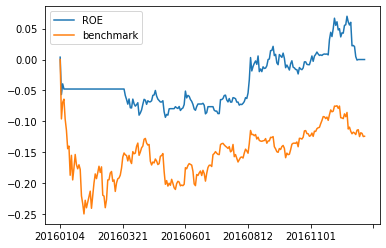

In [126]:
run()

In [105]:
print(context.positions)

{'601318': 2790100}


In [51]:
get_today_data('002309')

,open,high,low,close,volume,preClose


In [49]:
order_target_amount('601318', 30)

adjusted to buyable amount -200


In [33]:
context = Context(market, 100000000, '20230101', '20240101')
print(context.date_range)

['20230103', '20230104', '20230105', '20230106', '20230109', '20230110', '20230111', '20230112', '20230113', '20230116', '20230117', '20230118', '20230119', '20230120', '20230130', '20230131', '20230201', '20230202', '20230203', '20230206', '20230207', '20230208', '20230209', '20230210', '20230213', '20230214', '20230215', '20230216', '20230217', '20230220', '20230221', '20230222', '20230223', '20230224', '20230227', '20230228', '20230301', '20230302', '20230303', '20230306', '20230307', '20230308', '20230309', '20230310', '20230313', '20230314', '20230315', '20230316', '20230317', '20230320', '20230321', '20230322', '20230323', '20230324', '20230327', '20230328', '20230329', '20230330', '20230331', '20230403', '20230404', '20230406', '20230407', '20230410', '20230411', '20230412', '20230413', '20230414', '20230417', '20230418', '20230419', '20230420', '20230421', '20230424', '20230425', '20230426', '20230427', '20230428', '20230504', '20230505', '20230508', '20230509', '20230510', '20

In [50]:
print(context.positions)

{'601318': 100}


In [53]:
get_hist_data_by_count('002309',5)

NameError: name 'hist_start' is not defined

In [66]:
code='000001.SH'
fields=['open', 'close', 'high', 'low', 'volume', 'preClose']
xtdata.download_history_data(code, '1d', '20240101', '20240425')

ret = xtdata.get_market_data_ex(field_list=fields,
                                    stock_list=[code],
                                    period='1d',
                                    start_time='20240410',
                                    end_time='20240425',
                                    count=-1
            )

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xtquant import xtdata
import datetime
import dateutil

class Context:
    def __init__(self, market, cash, bkt_start_date, bkt_end_date):
        self.market = market
        self.cash = cash
        self.bkt_start_date = bkt_start_date
        self.bkt_end_date = bkt_end_date
        self.positions = {}
        self.benchmark = None
        self.date_range = xtdata.get_trading_calendar(market, bkt_start_date, bkt_end_date)
        self.bkt_dt = None

class G:
    pass

def set_benchmark(code):
    context.benchmark = code

def get_hist_data_by_count(code, count, fields=['open', 'close', 'high', 'low', 'volume', 'preClose']):
    hist_end_date = (dateutil.parser.parse(context.bkt_dt) - datetime.timedelta(days=1)).strftime("%Y%m%d")

    trd_calendar = xtdata.get_trading_calendar(context.market)
    hist_start_date = [dt for dt in trd_calendar if dt <= hist_end_date][-count:][0]

    _period = '1d'
    code = code+"."+context.market
    xtdata.download_history_data(code, _period, hist_start_date, hist_end_date)

    ret = xtdata.get_market_data_ex(field_list=fields,
                                    stock_list=[code],
                                    period=_period,
                                    start_time='',
                                    end_time=hist_end_date,
                                    count=count
            )[code]

    return ret

def get_hist_data_by_daterange(code, hist_start_date, hist_end_date, fields=['open', 'close', 'high', 'low', 'volume', 'preClose']):
    _period = '1d'
    code = code+"."+context.market
    xtdata.download_history_data(code, _period, hist_start_date, hist_end_date)

    ret = xtdata.get_market_data_ex(field_list=fields,
                                    stock_list=[code],
                                    period=_period,
                                    start_time=hist_start_date,
                                    end_time=hist_end_date,
                                    count=-1
            )[code]

    return ret

def get_today_data(code, fields=['open', 'close', 'high', 'low', 'volume', 'preClose']):
    _period = '1d'
    _count = 1
    code = code+"."+context.market
    today = context.bkt_dt
    xtdata.download_history_data(code, _period, today, today)

    try:
        ret = xtdata.get_market_data_ex(field_list=fields,
                stock_list=[code],
                period=_period,
                start_time='',
                end_time=today,
                count=_count
                )[code]
    except KeyError:
        ret = pd.Series()

    return ret

def _order(code, amount):
    print('trading amount %d' % amount)
    today_data = get_today_data(code)
    if len(today_data) == 0:
        print('no trading today')
        return

    price = today_data['open'].values[0]
    if context.cash - amount * price < 0:
        amount = int(context.cash / price)
        print('not enough cash, adjusted to %d' %(amount))

    if amount % 100 != 0:
        #if sold all you have, not need to adjust
        if amount != -context.positions.get(code, 0):
            amount = int(amount / 100) * 100
            print('adjusted to buyable amount %d' % amount)

    # adjust when selling all you have
    if context.positions.get(code, 0) < -amount:
        amount = context.positions.get(code, 0)
        print('can not sell security exceding the account holding, adjusted to %d' % amount)

    context.positions[code] = context.positions.get(code, 0) + amount
    if context.positions[code] == 0:
        del context.positions[code]

    context.cash -= amount * price

def order(code, amount):
    _order(code, amount)

# buy stock to target amount
def order_target_amount(code, target):
    if target < 0:
        print("target should not be less than 0")
        target = 0

    #TODO: considering T+1 trade: closable amount & total amount
    hold_amount = context.positions.get(code, 0)
    delta_amount = target - hold_amount
    _order(code, delta_amount)

# buy stock of specific value
def order_value(code, value):
    today_data = get_today_data(code)
    amount = int(value / today_data['open'].values[0])
    _order(code, amount)

# buy stock to target value
def order_target_value(code, target):
    if target < 0:
        print("target should not be less than 0")
        target = 0

    today_data = get_today_data(code)
    price = today_data['open'].values[0]
    hold_value = context.positions.get(code, 0) * price

    delta_value = target - hold_value
    order_value(code, delta_value)


def run():
    initialize(context)
    plt_df = pd.DataFrame(index=context.date_range, columns=['price','value'])
    init_value = context.cash
    for dt in context.date_range:
        context.bkt_dt = dt
        handle_data(context)
        
        value = context.cash
        last_price = {}
        for stock in context.positions:
            today_data = get_today_data(stock)
            # stock suspended
            if len(today_data) == 0:
                # if stock suspended on the first day, you won't have it in your context.positions
                price = last_price[stock]
            else:
                price = today_data['open'].values[0]
                last_price[stock] = price
            value += price * context.positions[stock]
            print('dt', dt)
            print('price', price)
            print('value', value)
        plt_df.loc[dt, 'price'] = price
        plt_df.loc[dt, 'value'] = value
    plt_df['ROE'] = (plt_df['value'] - init_value) / init_value
    bm_df = get_hist_data_by_daterange(context.benchmark, context.bkt_start_date, context.bkt_end_date)
    bm_init = bm_df['open'][0]
    plt_df['benchmark'] = (bm_df['open'] - bm_init) / bm_init

    plt_df[['ROE', 'benchmark']].plot()
    plt.show()
    plt_df.to_csv('plt_df.csv', index=True)


def initialize(context):
    set_benchmark('000001')
    g.p1 = 5
    g.p2 = 60
    g.code = '601318'

def handle_data(context):
    hist_data = get_hist_data_by_count(g.code, g.p2)
    ma5 = hist_data['open'][-5:].mean()
    ma60 = hist_data['open'].mean()

    if ma5 > ma60 and g.code not in context.positions:
        order_value(g.code, context.cash)
    elif ma5 < ma60 and g.code in context.positions:
        order_target_amount(g.code, 0)


['20140102', '20140103', '20140106', '20140107', '20140108', '20140109', '20140110', '20140113', '20140114', '20140115', '20140116', '20140117', '20140120', '20140121', '20140122', '20140123', '20140124', '20140127', '20140128', '20140129', '20140130', '20140207', '20140210', '20140211', '20140212', '20140213', '20140214', '20140217', '20140218', '20140219', '20140220', '20140221', '20140224', '20140225', '20140226', '20140227', '20140228', '20140303', '20140304', '20140305', '20140306', '20140307', '20140310', '20140311', '20140312', '20140313', '20140314', '20140317', '20140318', '20140319', '20140320', '20140321', '20140324', '20140325', '20140326', '20140327', '20140328', '20140331', '20140401', '20140402', '20140403', '20140404', '20140408', '20140409', '20140410', '20140411', '20140414', '20140415', '20140416', '20140417', '20140418', '20140421', '20140422', '20140423', '20140424', '20140425', '20140428', '20140429', '20140430', '20140505', '20140506', '20140507', '20140508', '20

trading amount 2404424
adjusted to buyable amount 2404400
dt 20140102
price 41.59
value 100000000.0
dt 20140103
price 40.699999999999996
value 97860083.99999997
dt 20140106
price 40.18
value 96609795.99999999
dt 20140107
price 39.63
value 95287375.99999999
dt 20140108
price 40.19
value 96633839.99999999
dt 20140109
price 40.5
value 97379203.99999999
dt 20140110
price 39.96
value 96080827.99999999
dt 20140113
price 39.730000000000004
value 95527816.0
dt 20140114
price 39.5
value 94974803.99999999
dt 20140115
price 39.93000000000001
value 96008696.0
dt 20140116
price 39.760000000000005
value 95599948.0
dt 20140117
price 41.03
value 98653535.99999999
dt 20140120
price 40.6
value 97619643.99999999
dt 20140121
price 40.800000000000004
value 98100524.0
dt 20140122
price 41.31
value 99326767.99999999
dt 20140123
price 41.6
value 100024043.99999999
dt 20140124
price 40.62
value 97667731.99999999
dt 20140127
price 39.98
value 96128915.99999997
dt 20140128
price 39.1
value 94013043.99999999
dt 2

dt 20141226
price 63.99
value 145265230.0
dt 20141229
price 70.52
value 160088983.0
dt 20141230
price 70.16
value 159271747.0
dt 20141231
price 73.5
value 166853881.0
dt 20150105
price 77.8
value 176615311.0
dt 20150106
price 74.38000000000001
value 168851569.0
dt 20150107
price 73.3
value 166399861.0
dt 20150108
price 74.5
value 169123981.0
dt 20150109
price 71.2
value 161632651.0
dt 20150112
price 73.98
value 167943529.0
dt 20150113
price 75.30000000000001
value 170940061.0
dt 20150114
price 75.26
value 170849257.0
dt 20150115
price 74.0
value 167988931.0
dt 20150116
price 79.39999999999999
value 180247470.99999994
dt 20150119
price 70.47000000000001
value 159975478.0
dt 20150120
price 70.3
value 159589561.0
dt 20150121
price 71.3
value 161859661.0
dt 20150122
price 77.29
value 175457560.0
dt 20150123
price 76.0
value 172529131.0
dt 20150126
price 76.3
value 173210161.0
dt 20150127
price 76.12
value 172801543.0
dt 20150128
price 72.89
value 165469120.0
dt 20150129
price 71.01
value 1

dt 20160407
price 31.89
value 159243746.0
dt 20160408
price 31.2
value 155798231.0
dt 20160411
price 31.32
value 156397451.0
dt 20160412
price 31.490000000000002
value 157246346.0
dt 20160413
price 31.8
value 158794331.0
dt 20160414
price 32.08
value 160192511.0
dt 20160415
price 32.03
value 159942836.0
dt 20160418
price 31.8
value 158794331.0
dt 20160419
price 32.0
value 159793031.0
dt 20160420
price 31.939999999999998
value 159493421.0
dt 20160421
price 31.939999999999998
value 159493421.0
dt 20160422
price 32.0
value 159793031.0
dt 20160425
price 32.300000000000004
value 161291081.00000003
dt 20160426
price 32.32
value 161390951.0
dt 20160427
price 32.57
value 162639326.0
dt 20160428
price 32.26
value 161091341.0
dt 20160429
price 32.089999999999996
value 160242445.99999997
dt 20160503
price 32.01
value 159842966.0
dt 20160504
price 31.93
value 159443486.0
dt 20160505
price 31.93
value 159443486.0
dt 20160506
price 32.0
value 159793031.0
dt 20160509
price 31.39
value 156746996.0
dt 

dt 20161214
price 36.63
value 180788704.99999994
dt 20161215
price 36.78
value 181529029.99999994
dt 20161216
price 35.46
value 175014169.99999994
dt 20161219
price 35.480000000000004
value 175112879.99999997
dt 20161220
price 35.42
value 174816749.99999994
dt 20161221
price 34.85
value 172003514.99999994
dt 20161222
price 34.66
value 171065769.9999999
trading amount -4935500
trading amount 4791878
adjusted to buyable amount 4791800
dt 20170105
price 35.73
value 171213834.99999994
dt 20170106
price 35.730000000000004
value 171213835.0
dt 20170109
price 35.470000000000006
value 169967967.0
dt 20170110
price 35.440000000000005
value 169824213.0
dt 20170111
price 35.25
value 168913770.99999997
dt 20170112
price 35.3
value 169153360.99999997
dt 20170113
price 35.23
value 168817934.99999994
trading amount -4791800
trading amount 4716280
adjusted to buyable amount 4716200
dt 20170119
price 36.13
value 170399228.99999997
dt 20170120
price 36.05
value 170021932.99999997
dt 20170123
price 36.26

dt 20170906
price 56.050000000000004
value 249839086.99999997
dt 20170907
price 55.6
value 247833256.99999994
dt 20170908
price 54.9
value 244713076.99999994
dt 20170911
price 55.21
value 246094870.99999994
dt 20170912
price 54.48
value 242840968.99999994
dt 20170913
price 54.8
value 244267336.99999994
dt 20170914
price 55.1
value 245604556.99999994
dt 20170915
price 54.089999999999996
value 241102582.9999999
dt 20170918
price 53.27
value 237447514.99999994
dt 20170919
price 53.69
value 239319622.99999994
dt 20170920
price 53.44
value 238205272.99999994
dt 20170921
price 53.16
value 236957200.9999999
dt 20170922
price 53.550000000000004
value 238695586.99999997
dt 20170925
price 54.05
value 240924286.99999994
dt 20170926
price 53.99
value 240656842.99999994
dt 20170927
price 54.1
value 241147156.99999994
dt 20170928
price 53.6
value 238918456.99999994
dt 20170929
price 53.72
value 239453344.99999994
dt 20171009
price 56.1
value 250061956.99999994
dt 20171010
price 54.86
value 244534780

dt 20181105
price 66.5
value 272950468.9999999
dt 20181106
price 66.2
value 271719118.9999999
dt 20181107
price 66.89
value 274551223.9999999
dt 20181108
price 66.93
value 274715403.9999999
dt 20181109
price 65.75
value 269872093.9999999
dt 20181112
price 64.4
value 264331018.99999994
dt 20181113
price 63.78
value 261786228.9999999
dt 20181114
price 65.05
value 266998943.9999999
dt 20181115
price 64.0
value 262689218.9999999
dt 20181116
price 65.0
value 266793718.9999999
dt 20181119
price 65.25
value 267819843.9999999
dt 20181120
price 65.0
value 266793718.9999999
dt 20181121
price 63.53
value 260760103.9999999
dt 20181122
price 64.18
value 263428028.99999994
dt 20181123
price 63.150000000000006
value 259200393.99999994
trading amount -4104500
trading amount 4072200
dt 20190201
price 63.5
value 258584718.99999994
dt 20190211
price 62.88
value 256059954.99999994
dt 20190212
price 64.4
value 262249698.99999997
dt 20190213
price 64.66
value 263308470.99999994
dt 20190214
price 64.88
value

dt 20190920
price 89.89
value 342336355.99999994
dt 20190923
price 89.44000000000001
value 340622621.0
dt 20190924
price 89.0
value 338946968.99999994
dt 20190925
price 88.39
value 336623905.99999994
dt 20190926
price 89.2
value 339708628.99999994
dt 20190927
price 88.53
value 337157067.99999994
dt 20190930
price 87.94000000000001
value 334910171.0
dt 20191008
price 87.14000000000001
value 331863531.0
dt 20191009
price 87.44
value 333006020.99999994
dt 20191010
price 88.19000000000001
value 335862246.0
trading amount -3808300
trading amount 3728282
adjusted to buyable amount 3728200
dt 20191015
price 90.8
value 338528055.99999994
dt 20191016
price 90.7
value 338155235.99999994
dt 20191017
price 91.2
value 340019335.99999994
dt 20191018
price 92.30000000000001
value 344120356.0
dt 20191021
price 89.47000000000001
value 333569550.0
dt 20191022
price 90.78999999999999
value 338490773.99999994
dt 20191023
price 90.2
value 336291135.99999994
dt 20191024
price 89.85000000000001
value 3349862

dt 20201225
price 83.6
value 258773890.99999994
dt 20201228
price 83.45
value 258309595.99999997
dt 20201229
price 84.95
value 262952545.99999997
dt 20201230
price 85.2
value 263726370.99999997
dt 20201231
price 85.59
value 264933537.99999997
dt 20210104
price 86.91000000000001
value 269019334.0
dt 20210105
price 84.50000000000001
value 261559661.0
dt 20210106
price 84.28999999999999
value 260909647.99999994
dt 20210107
price 85.86999999999999
value 265800221.99999994
dt 20210108
price 86.22000000000001
value 266883577.0
dt 20210111
price 86.2
value 266821670.99999997
dt 20210112
price 83.88
value 259640574.99999997
dt 20210113
price 88.8
value 274869451.0
dt 20210114
price 88.39999999999999
value 273631331.0
dt 20210115
price 85.94
value 266016892.99999997
dt 20210118
price 87.0
value 269297911.0
dt 20210119
price 87.58000000000001
value 271093185.0
dt 20210120
price 87.11999999999999
value 269669346.9999999
dt 20210121
price 85.36
value 264221618.99999997
dt 20210122
price 85.0
value

dt 20230106
price 49.50000000000001
value 245279140.99999994
dt 20230109
price 50.0
value 247756690.9999999
dt 20230110
price 50.9
value 252216280.9999999
dt 20230111
price 49.5
value 245279140.9999999
dt 20230112
price 50.9
value 252216280.9999999
dt 20230113
price 51.2
value 253702810.9999999
dt 20230116
price 52.52
value 260243542.99999994
dt 20230117
price 51.96
value 257468686.9999999
dt 20230118
price 51.50000000000001
value 255189340.99999994
dt 20230119
price 51.4
value 254693830.9999999
dt 20230120
price 52.1
value 258162400.9999999
dt 20230130
price 53.59
value 265545499.99999994
dt 20230131
price 51.76
value 256477666.9999999
dt 20230201
price 51.550000000000004
value 255437095.99999994
dt 20230202
price 51.6
value 255684850.9999999
dt 20230203
price 50.5
value 250234240.9999999
dt 20230206
price 48.8
value 241810570.9999999
dt 20230207
price 48.5
value 240324040.9999999
dt 20230208
price 48.75
value 241562815.9999999
dt 20230209
price 48.5
value 240324040.9999999
dt 2023021

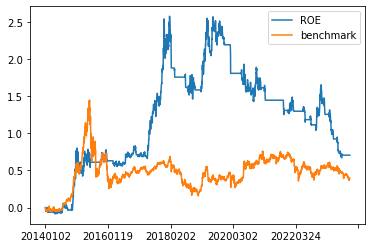

In [254]:
if __name__ == '__main__':
    #TODO: what if the portfolio inclue equity across the market
    market = 'SH'
    global context 
    global g
    context = Context(market, 100000000, '20140101', '20240101')
    print(context.date_range)
    run()

In [255]:
plt_df = pd.read_csv('plt_df.csv')
plt_df.tail(10)

,Unnamed: 0,price,value,ROE,benchmark
2423,20231219,49.05,170630567.0,0.706306,0.386642
2424,20231220,49.05,170630567.0,0.706306,0.388231
2425,20231221,49.05,170630567.0,0.706306,0.369246
2426,20231222,49.05,170630567.0,0.706306,0.382156
2427,20231225,49.05,170630567.0,0.706306,0.377700
2428,20231226,49.05,170630567.0,0.706306,0.381532
2429,20231227,49.05,170630567.0,0.706306,0.373095
2430,20231228,49.05,170630567.0,0.706306,0.379231
2431,20231229,49.05,170630567.0,0.706306,0.397093
2432,20240101,49.05,170630567.0,0.706306,NaN


# BackTrader

In [5]:
del matplotlib

NameError: name 'matplotlib' is not defined

回测框架开始运行，初始资金： 1000000
3770.2876000000006 3768.9254
<backtrader.linebuffer.LineBuffer object at 0x0000019A3C80E690> <backtrader.linebuffer.LineBuffer object at 0x0000019A3C80E690>
买入日期：2025-01-15 
 当日之前2日收盘价：3722.513 
 当日之前1日收盘价：3820.54 
 当日收盘价：3796.027 
 当日收盘价与前1日收盘价差：-24.51 

发出买入信号当日前2日close值：array('d', [3722.513, 3820.54])
卖出日期：2025-01-27 

3818.321 3809.1580000000004
<backtrader.linebuffer.LineBuffer object at 0x0000019A3C80E690> <backtrader.linebuffer.LineBuffer object at 0x0000019A3C80E690>
买入日期：2025-02-06 
 当日之前2日收盘价：3817.08 
 当日之前1日收盘价：3795.085 
 当日收盘价：3842.8320000000003 
 当日收盘价与前1日收盘价差：47.75 

发出买入信号当日前2日close值：array('d', [3817.08, 3795.085])
卖出日期：2025-02-28 

3915.3032 3904.5099999999998
<backtrader.linebuffer.LineBuffer object at 0x0000019A3C80E690> <backtrader.linebuffer.LineBuffer object at 0x0000019A3C80E690>
买入日期：2025-03-07 
 当日之前2日收盘价：3902.5710000000004 
 当日之前1日收盘价：3956.237 
 当日收盘价：3944.014 
 当日收盘价与前1日收盘价差：-12.22 

发出买入信号当日前2日close值：array('d', [3902.5710000000004, 3956

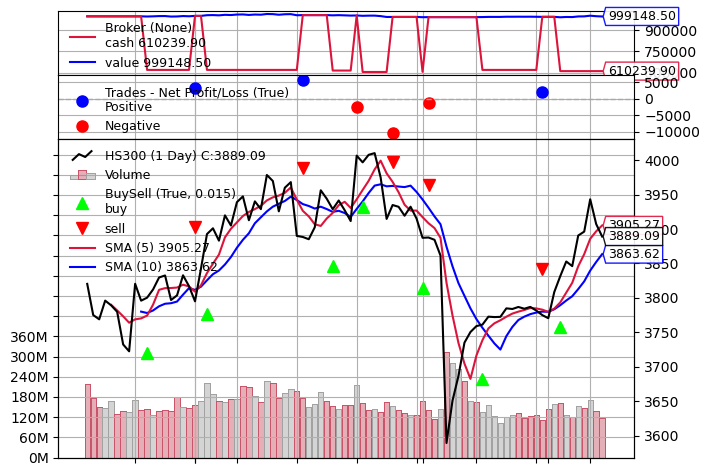

[[<Figure size 640x480 with 4 Axes>]]

In [115]:
%matplotlib inline
import backtrader as bt
from datetime import datetime
import backtrader.indicators as btin
import backtrader.talib as btta

class MyStrategy(bt.Strategy):
    # 设置自定义策略的params参数。
    params = (('short', 5), ('long', 10))

    # 定义初始化函数。
    def __init__(self,a,b):
        self.start_cash = self.broker.getcash()
        print("回测框架开始运行，初始资金：",self.broker.getcash())
        # 调用backtrader自带指标SMA。
        self.bt_sma = btin.SMA(self.data, period=self.p.short)
        # 调用talib指标SMA。
        self.talib_sma = btta.SMA(self.data, timeperiod=self.p.long)
        # 计算当前收盘价与前一日收盘价差数据序列
        # 引入数据中整列数据序列与整列数据前一日数据序列的示例。
        self.dif = self.data0.close-self.data0.close(-1)

    # 定义next函数。
    def next(self):
        # 买入条件：①空仓；②短周期均线在长周期上方。
        if not self.position:
            # 引入指标数据当前值的示例。
            # self.bt_sma内部有lines属性，lines属性内部有sam属性，lines可以省略，sam也可以被省略。
            # self.talib_sma内部有lines属性，lines可以被省略。
            # [0]表示当前值，如果是[-1]就表示前一日对应值。
            if self.bt_sma.sma[0] > self.bt_sma.sma[-1]:
                print(self.bt_sma.sma[0], self.bt_sma.sma[-1])
                print(self.talib_sma.lines[0], self.talib_sma.lines[0])
                # self.data0有lines属性，lines属性内部包括datetime、close等属性，lines可以省略。
                print(f'买入日期：{self.data0.lines.datetime.date()}','\n',
              f'当日之前2日收盘价：{self.datas[0].close[-2]}','\n',
              f'当日之前1日收盘价：{self.datas[0].close[-1]}','\n',
              f'当日收盘价：{self.datas[0].close[0]}', '\n',
              f'当日收盘价与前1日收盘价差：{round(self.dif[0],2)}','\n')
                # 数据切片引用示例：取前一日过去2日close数据，前一日包含在内。
                print(f'发出买入信号当日前2日close值：{self.data.close.get(ago=-1,size=2)}')
                # 执行买入操作。
                self.buy()
        # 卖出条件：①非空仓；②短周期均线在长周期下方。
        if self.position:
            if self.bt_sma.sma[0] < self.bt_sma.sma[-1]:
                # 执行卖出操作。
                print(f'卖出日期：{self.data0.lines.datetime.date()}','\n')
                self.sell()

# 创建Cerebro引擎对象。
cerebro = bt.Cerebro()
# 将数据添加到Cerebro引擎中。
data = bt.feeds.GenericCSVData(
    dataname='HS300.csv',
    dtformat=('%Y%m%d'),
    fromdate=datetime(2025, 1, 1),
    todate=datetime(2025, 5, 19))
cerebro.adddata(data)
# 将策略添加到Cerebro引擎中。
# my_strategy = MyStrategy(1,2)
cerebro.addstrategy(MyStrategy,a=1,b=2)
# 设置初始资金为100000元。
cerebro.broker.setcash(1000000)
# 调取回测设置初始资金存储至start_cash变量。
start_cash = cerebro.broker.getcash()
# 设置每次交易的股票数量为1000股。
cerebro.addsizer(bt.sizers.FixedSize, stake=100)
cerebro.addanalyzer(bt.analyzers.Returns)
# 运行回测。
results = cerebro.run()
# 打印执行策略最终资产价值。
print('策略终值：%.2f' % cerebro.broker.getvalue())
# 调用回测结果中analyzer.returns的收益率值。
returns_bt = results[0].analyzers.returns.get_analysis()['rtot']
print(f'backtrader计算的收益率：{returns_bt:.2%}')

# 手工计算回测后的收益率。
final_portfolio_value = cerebro.broker.getvalue()
initial_portfolio_value = start_cash
returns_my = (final_portfolio_value - initial_portfolio_value) / initial_portfolio_value
print(f'手工计算的收益率：{returns_my:.2%}')
# 回测结果可视化输出（不显示成交量）。
#cerebro.plot(volume=False)
cerebro.plot(style='line',iplot=False)

AttributeError: 'Lines_LineSeries_LineIterator_DataAccessor_IndicatorBase_Indicator_MovingAverageBase_MovingAverageSi' object has no attribute 'plot'

初始资金: 10000.00
最终资金: 8761.78
夏普比率: OrderedDict({'sharperatio': -27.921338842585925})
最大回撤: AutoOrderedDict({'len': 280, 'drawdown': 13.674718954334422, 'moneydown': 1387.9464569999982, 'max': AutoOrderedDict({'len': 280, 'drawdown': 13.674718954334422, 'moneydown': 1387.9464569999982})})
收益率: OrderedDict({'rtot': -0.13218610467313585, 'ravg': -0.0004017814731706257, 'rnorm': -0.09629195627940547, 'rnorm100': -9.629195627940547})


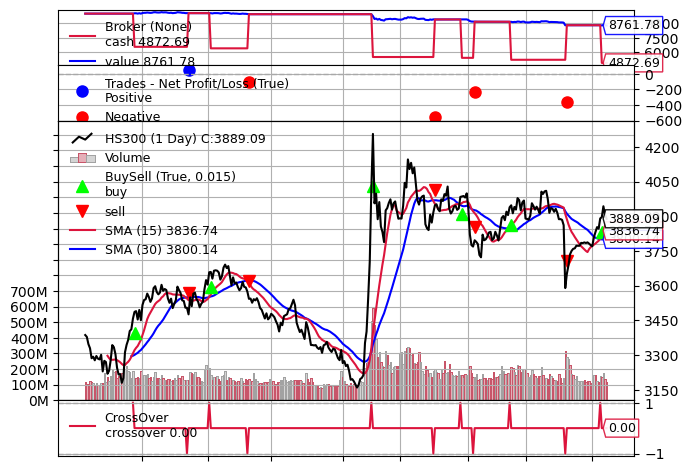

In [31]:
%matplotlib inline
import backtrader as bt
import pandas as pd
from datetime import datetime
from backtrader_plotting import Bokeh
from backtrader_plotting.schemes import Tradimo
# 定义策略
class SmaCross(bt.Strategy):
    params = (
        ('pfast', 15),  # 快速移动平均线周期
        ('pslow', 30),  # 慢速移动平均线周期
    )

    def __init__(self):
        # 初始化移动平均线指标
        self.sma_fast = bt.indicators.SMA(self.datas[0], period=self.p.pfast)
        self.sma_slow = bt.indicators.SMA(self.datas[0], period=self.p.pslow)
        self.crossover = bt.indicators.CrossOver(self.sma_fast, self.sma_slow)

    def next(self):
        if not self.position:  # 如果没有持仓
            if self.crossover > 0:  # 如果快速线上穿慢速线
                self.buy()  # 买入
        elif self.crossover < 0:  # 如果快速线下穿慢速线
            self.close()  # 平仓

# 准备数据
def run_backtest():
    # 创建回测引擎
    cerebro = bt.Cerebro()
    
    # 添加策略
    cerebro.addstrategy(SmaCross)
    
    # 创建模拟数据
    #data = bt.feeds.PandasData(
    #    dataname=pd.DataFrame({
    #        'open': [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
    #        'high': [102, 103, 104, 105, 106, 107, 108, 109, 110, 111],
    #        'low': [98, 99, 100, 101, 102, 103, 104, 105, 106, 107],
    #        'close': [101, 102, 103, 104, 105, 106, 107, 108, 109, 110],
    #        'volume': [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]
    #    })
    #)
    data = bt.feeds.GenericCSVData(
    dataname='HS300.csv',
    dtformat=('%Y%m%d'),
    fromdate=datetime(2024, 1, 1),
    todate=datetime(2025, 5, 19))
    # 添加数据
    cerebro.adddata(data)
    
    # 设置初始资金
    cerebro.broker.setcash(10000.0)
    
    # 设置手续费
    cerebro.broker.setcommission(commission=0.001)
    
    # 添加分析器
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    
    # 运行回测
    print('初始资金: %.2f' % cerebro.broker.getvalue())
    results = cerebro.run()
    print('最终资金: %.2f' % cerebro.broker.getvalue())
    
    # 输出分析结果
    strat = results[0]
    print('夏普比率:', strat.analyzers.sharpe.get_analysis())
    print('最大回撤:', strat.analyzers.drawdown.get_analysis())
    print('收益率:', strat.analyzers.returns.get_analysis())
    
    # 绘图
    b = Bokeh(style='bar', plot_mode='single', scheme=Tradimo())
    #cerebro.plot(b, iplot=False)
    cerebro.plot(style='line',iplot=False)

if __name__ == '__main__':
    run_backtest()

In [17]:
import backtrader as bt
import yfinance as yf
import pandas as pd

def backtest_with_real_data():
    cerebro = bt.Cerebro()
    
    # 添加策略
    cerebro.addstrategy(SmaCross)
    
    # 下载真实数据
    data = yf.download('AAPL', '2020-01-01', '2023-01-01')
    
    # 创建数据feed
    data_feed = bt.feeds.PandasData(dataname=data)
    cerebro.adddata(data_feed)
    
    # 设置回测参数
    cerebro.broker.setcash(10000.0)
    cerebro.broker.setcommission(commission=0.001)
    
    
    # 添加分析器
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    
    # 运行回测
    print('初始资金: %.2f' % cerebro.broker.getvalue())
    results = cerebro.run()
    print('最终资金: %.2f' % cerebro.broker.getvalue())
    
    # 输出详细结果
    strat = results[0]
    print("\n=== 回测结果 ===")
    print("夏普比率:", strat.analyzers.sharpe.get_analysis())
    print("年化收益率:", strat.analyzers.annual.get_analysis())
    print("交易统计:", strat.analyzers.trades.get_analysis())
    
    # 绘图
    cerebro.plot()

if __name__ == '__main__':
    backtest_with_real_data()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


初始资金: 10000.00


AttributeError: 'tuple' object has no attribute 'lower'

In [1]:
# 微行动：成功获取并打印出沪深300的前5行数据
from xtquant import xtdata

# 1. 获取数据
stock_code = '000300.SH'
period = '1d'  # 日线
count = 1000   # 获取1000条数据
hs300_data = xtdata.get_market_data(field_list=[], stock_list=[stock_code], period=period, count=count, dividend_type='front', fill_data=True)

# 2. 探索数据
print(hs300_data[stock_code].head()) # 查看前5行
print(hs300_data[stock_code].info()) # 查看数据信息

# 3. 简单可视化
import matplotlib.pyplot as plt
hs300_data[stock_code]['close'].plot(title='HS300 Close Price')
plt.show()

***** xtdata连接成功 *****
服务信息: {'tag': 'sp3', 'version': '1.0'}
服务地址: 127.0.0.1:58610
数据路径: D:\国金QMT交易端模拟\bin.x64/../userdata_mini/datadir
设置xtdata.enable_hello = False可隐藏此消息



KeyError: '000300.SH'

In [3]:
# 尝试获取板块成分股（如果该函数存在）
try:
    # 注意：函数名可能需要调整，如 get_stock_list_in_sector, get_plate_stock, 等
    hs300_constituents = xtdata.get_stock_list_in_sector('沪深300')
    print("沪深300成分股示例:", hs300_constituents[:5])  # 打印前5只成分股
except Exception as e:
    print("获取板块成分股出错，可能函数名不正确:", e)

沪深300成分股示例: ['600000.SH', '600009.SH', '600010.SH', '600011.SH', '600015.SH']


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xtquant import xtdata
import datetime
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class AdvancedStrategies:
    """高级策略库"""
    
    @staticmethod
    def dual_moving_average_cross(data, short_window=5, long_window=20):
        """双均线交叉策略"""
        if len(data) < long_window:
            return 0
        
        df = data.copy()
        df['short_ma'] = df['close'].rolling(window=short_window).mean()
        df['long_ma'] = df['close'].rolling(window=long_window).mean()
        
        current_short = df['short_ma'].iloc[-1]
        current_long = df['long_ma'].iloc[-1]
        
        if len(df) > 1:
            prev_short = df['short_ma'].iloc[-2]
            prev_long = df['long_ma'].iloc[-2]
        else:
            return 0
        
        # 金叉买入，死叉卖出
        if prev_short <= prev_long and current_short > current_long:
            return 1
        elif prev_short >= prev_long and current_short < current_long:
            return -1
        else:
            return 0
    
    @staticmethod
    def rsi_mean_reversion(data, period=14, oversold=30, overbought=70):
        """RSI均值回归策略"""
        if len(data) < period + 1:
            return 0
        
        df = data.copy()
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        
        current_rsi = rsi.iloc[-1]
        
        if current_rsi < oversold:
            return 1  # 超卖，买入
        elif current_rsi > overbought:
            return -1  # 超买，卖出
        else:
            return 0
    
    @staticmethod
    def bollinger_breakout(data, period=20, num_std=2):
        """布林带突破策略"""
        if len(data) < period:
            return 0
        
        df = data.copy()
        df['middle_band'] = df['close'].rolling(window=period).mean()
        df['std'] = df['close'].rolling(window=period).std()
        df['upper_band'] = df['middle_band'] + (df['std'] * num_std)
        df['lower_band'] = df['middle_band'] - (df['std'] * num_std)
        
        current_close = df['close'].iloc[-1]
        current_upper = df['upper_band'].iloc[-1]
        current_lower = df['lower_band'].iloc[-1]
        prev_close = df['close'].iloc[-2] if len(df) > 1 else current_close
        
        # 上突破买入，下突破卖出
        if prev_close <= current_upper and current_close > current_upper:
            return 1
        elif prev_close >= current_lower and current_close < current_lower:
            return -1
        else:
            return 0
    
    @staticmethod
    def macd_crossover(data, fast_period=12, slow_period=26, signal_period=9):
        """MACD交叉策略"""
        if len(data) < slow_period + signal_period:
            return 0
        
        df = data.copy()
        exp1 = df['close'].ewm(span=fast_period, adjust=False).mean()
        exp2 = df['close'].ewm(span=slow_period, adjust=False).mean()
        macd = exp1 - exp2
        signal = macd.ewm(span=signal_period, adjust=False).mean()
        histogram = macd - signal
        
        current_macd = macd.iloc[-1]
        current_signal = signal.iloc[-1]
        prev_macd = macd.iloc[-2] if len(macd) > 1 else current_macd
        prev_signal = signal.iloc[-2] if len(signal) > 1 else current_signal
        
        # MACD上穿信号线买入，下穿信号线卖出
        if prev_macd <= prev_signal and current_macd > current_signal:
            return 1
        elif prev_macd >= prev_signal and current_macd < current_signal:
            return -1
        else:
            return 0
    
    @staticmethod
    def volume_price_confirmation(data, volume_period=20):
        """量价确认策略"""
        if len(data) < volume_period:
            return 0
        
        df = data.copy()
        df['price_change'] = df['close'].pct_change()
        df['volume_ma'] = df['volume'].rolling(window=volume_period).mean()
        df['volume_ratio'] = df['volume'] / df['volume_ma']
        
        current_price_change = df['price_change'].iloc[-1]
        current_volume_ratio = df['volume_ratio'].iloc[-1]
        prev_price_change = df['price_change'].iloc[-2] if len(df) > 1 else 0
        
        # 价涨量增买入，价跌量增卖出
        if current_price_change > 0 and current_volume_ratio > 1.2:
            return 1
        elif current_price_change < 0 and current_volume_ratio > 1.2:
            return -1
        else:
            return 0
    
    @staticmethod
    def mean_reversion(data, lookback=20, z_threshold=2):
        """均值回归策略（Z-score）"""
        if len(data) < lookback:
            return 0
        
        df = data.copy()
        returns = df['close'].pct_change().dropna()
        
        if len(returns) < lookback:
            return 0
        
        current_return = returns.iloc[-1]
        mean_return = returns.tail(lookback).mean()
        std_return = returns.tail(lookback).std()
        
        if std_return == 0:
            return 0
        
        z_score = (current_return - mean_return) / std_return
        
        # Z-score极端值回归
        if z_score < -z_threshold:
            return 1  # 超卖回归
        elif z_score > z_threshold:
            return -1  # 超买回归
        else:
            return 0
    
    @staticmethod
    def momentum_strategy(data, momentum_period=10, ma_period=20):
        """动量策略"""
        if len(data) < max(momentum_period, ma_period):
            return 0
        
        df = data.copy()
        df['momentum'] = df['close'] / df['close'].shift(momentum_period) - 1
        df['ma'] = df['close'].rolling(window=ma_period).mean()
        
        current_momentum = df['momentum'].iloc[-1]
        current_close = df['close'].iloc[-1]
        current_ma = df['ma'].iloc[-1]
        
        # 动量强劲且价格在均线上方买入
        if current_momentum > 0.02 and current_close > current_ma:
            return 1
        # 负动量且价格在均线下方卖出
        elif current_momentum < -0.02 and current_close < current_ma:
            return -1
        else:
            return 0

class MultiStrategyBacktest:
    """多策略回测框架"""
    
    def __init__(self, initial_capital=1000000):
        self.initial_capital = initial_capital
        self.strategy_results = {}
        self.comparison_results = {}
        
    def run_strategy_comparison(self, stock_data_dict, strategies_dict, 
                              start_date=None, end_date=None,
                              capital_per_stock=100000):
        """
        运行多策略比较回测
        
        Parameters:
        stock_data_dict: 股票数据字典
        strategies_dict: 策略字典，{策略名称: 策略函数}
        """
        print("=" * 80)
        print("多策略回测比较")
        print("=" * 80)
        print(f"策略数量: {len(strategies_dict)}")
        print(f"股票数量: {len(stock_data_dict)}")
        print(f"时间范围: {start_date} 到 {end_date}")
        print("=" * 80)
        
        for strategy_name, strategy_func in strategies_dict.items():
            print(f"\n正在运行策略: {strategy_name}")
            
            portfolio_backtest = PortfolioBacktest(initial_capital=self.initial_capital)
            portfolio_backtest.run_stock_universe_backtest(
                stock_data_dict=stock_data_dict,
                strategy_function=strategy_func,
                start_date=start_date,
                end_date=end_date,
                capital_per_stock=capital_per_stock
            )
            
            # 保存策略结果
            self.strategy_results[strategy_name] = portfolio_backtest
            self.comparison_results[strategy_name] = portfolio_backtest.get_portfolio_metrics()
            
            # 打印策略简要结果
            metrics = self.comparison_results[strategy_name]
            print(f"{strategy_name} - 总收益: {metrics['portfolio_total_return']:.2%} | "
                  f"年化收益: {metrics['avg_annual_return']:.2%} | "
                  f"夏普比率: {metrics['avg_sharpe_ratio']:.2f}")
    
    def print_strategy_comparison(self):
        """打印策略比较报告"""
        if not self.comparison_results:
            print("没有可比较的结果")
            return
        
        print("\n" + "=" * 100)
        print("多策略比较报告")
        print("=" * 100)
        
        # 创建比较表格
        comparison_df = pd.DataFrame(self.comparison_results).T
        comparison_df = comparison_df.sort_values('portfolio_total_return', ascending=False)
        
        # 选择关键指标显示
        key_metrics = [
            'portfolio_total_return', 'avg_annual_return', 'avg_sharpe_ratio',
            'avg_max_drawdown', 'avg_win_rate', 'positive_return_ratio', 'total_trades'
        ]
        
        display_df = comparison_df[key_metrics].copy()
        display_df.columns = ['总收益率', '年化收益率', '夏普比率', '平均最大回撤', 
                            '平均胜率', '正收益比例', '总交易次数']
        
        # 格式化显示
        formatted_df = display_df.copy()
        formatted_df['总收益率'] = formatted_df['总收益率'].apply(lambda x: f"{x:.2%}")
        formatted_df['年化收益率'] = formatted_df['年化收益率'].apply(lambda x: f"{x:.2%}")
        formatted_df['平均最大回撤'] = formatted_df['平均最大回撤'].apply(lambda x: f"{x:.2%}")
        formatted_df['平均胜率'] = formatted_df['平均胜率'].apply(lambda x: f"{x:.2%}")
        formatted_df['正收益比例'] = formatted_df['正收益比例'].apply(lambda x: f"{x:.2%}")
        formatted_df['夏普比率'] = formatted_df['夏普比率'].apply(lambda x: f"{x:.2f}")
        
        print(formatted_df.to_string())
        print("=" * 100)
        
        # 找出最佳策略
        best_strategy = comparison_df['portfolio_total_return'].idxmax()
        best_return = comparison_df.loc[best_strategy, 'portfolio_total_return']
        
        print(f"\n🎯 最佳策略: {best_strategy} (总收益: {best_return:.2%})")
        
        return comparison_df
    
    def plot_strategy_comparison(self):
        """绘制策略比较图"""
        if not self.strategy_results:
            print("没有策略结果可比较")
            return
        
        plt.figure(figsize=(16, 12))
        
        # 1. 策略收益对比
        plt.subplot(2, 2, 1)
        strategy_returns = {name: result.get_portfolio_metrics()['portfolio_total_return'] 
                          for name, result in self.strategy_results.items()}
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(strategy_returns)))
        bars = plt.bar(strategy_returns.keys(), strategy_returns.values(), color=colors)
        plt.title('策略总收益对比')
        plt.ylabel('总收益率')
        plt.xticks(rotation=45)
        
        # 在柱状图上添加数值
        for bar, value in zip(bars, strategy_returns.values()):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{value:.2%}', ha='center', va='bottom')
        
        # 2. 夏普比率对比
        plt.subplot(2, 2, 2)
        strategy_sharpes = {name: result.get_portfolio_metrics()['avg_sharpe_ratio'] 
                          for name, result in self.strategy_results.items()}
        
        colors = plt.cm.Pastel1(np.linspace(0, 1, len(strategy_sharpes)))
        bars = plt.bar(strategy_sharpes.keys(), strategy_sharpes.values(), color=colors)
        plt.title('策略夏普比率对比')
        plt.ylabel('夏普比率')
        plt.xticks(rotation=45)
        
        # 3. 最大回撤对比
        plt.subplot(2, 2, 3)
        strategy_drawdowns = {name: result.get_portfolio_metrics()['avg_max_drawdown'] 
                            for name, result in self.strategy_results.items()}
        
        colors = plt.cm.Set2(np.linspace(0, 1, len(strategy_drawdowns)))
        bars = plt.bar(strategy_drawdowns.keys(), strategy_drawdowns.values(), color=colors)
        plt.title('策略最大回撤对比')
        plt.ylabel('最大回撤')
        plt.xticks(rotation=45)
        
        # 4. 胜率对比
        plt.subplot(2, 2, 4)
        strategy_winrates = {name: result.get_portfolio_metrics()['avg_win_rate'] 
                           for name, result in self.strategy_results.items()}
        
        colors = plt.cm.Paired(np.linspace(0, 1, len(strategy_winrates)))
        bars = plt.bar(strategy_winrates.keys(), strategy_winrates.values(), color=colors)
        plt.title('策略胜率对比')
        plt.ylabel('胜率')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()

# 原有的 StockBacktest 和 PortfolioBacktest 类保持不变
# 这里省略重复代码，只展示新增内容

def run_advanced_strategy_test():
    """运行高级策略测试"""
    print("🚀 开始高级策略回测比较")
    
    # 获取股票列表
    stock_codes = get_hs300_stock_list()[:20]  # 使用前20只股票进行快速测试
    print(f"使用 {len(stock_codes)} 只股票进行测试")
    
    # 获取数据
    stock_data_dict = generate_hs300_sample_data(
        stock_codes, 
        start_date='20230101', 
        end_date='20231231'
    )
    
    if not stock_data_dict:
        print("错误: 无法获取股票数据")
        return
    
    # 定义策略集合
    strategies = {
        "双均线交叉": lambda x: AdvancedStrategies.dual_moving_average_cross(x, 5, 20),
        "RSI均值回归": lambda x: AdvancedStrategies.rsi_mean_reversion(x, 14, 30, 70),
        "布林带突破": lambda x: AdvancedStrategies.bollinger_breakout(x, 20, 2),
        "MACD交叉": lambda x: AdvancedStrategies.macd_crossover(x, 12, 26, 9),
        "量价确认": lambda x: AdvancedStrategies.volume_price_confirmation(x, 20),
        "均值回归": lambda x: AdvancedStrategies.mean_reversion(x, 20, 2),
        "动量策略": lambda x: AdvancedStrategies.momentum_strategy(x, 10, 20)
    }
    
    # 运行多策略比较
    multi_backtest = MultiStrategyBacktest(initial_capital=500000)
    multi_backtest.run_strategy_comparison(
        stock_data_dict=stock_data_dict,
        strategies_dict=strategies,
        start_date='20230101',
        end_date='20231231',
        capital_per_stock=20000
    )
    
    # 生成比较报告
    comparison_df = multi_backtest.print_strategy_comparison()
    
    # 绘制比较图表
    multi_backtest.plot_strategy_comparison()
    
    # 显示最佳策略的详细报告
    best_strategy_name = comparison_df['portfolio_total_return'].idxmax()
    print(f"\n📊 最佳策略 '{best_strategy_name}' 的详细报告:")
    print("=" * 70)
    multi_backtest.strategy_results[best_strategy_name].print_detailed_report()
    
    return multi_backtest

# 主函数更新
def main():
    """主函数"""
    # 运行高级策略测试
    run_advanced_strategy_test()

if __name__ == "__main__":
    main()

🚀 开始高级策略回测比较


NameError: name 'get_hs300_stock_list' is not defined